## Fast Gradient Sign Method Attack

Adverserial attack aims at misleading, evading or decieving a machine learning model by introducing small and often imperceptible  perturbations (noise). In this regard, **Fast Gradient Sign Method (FGSM)**, aims at introducing peturbation that optimize the input data to maximize the prediction error of a model. 

The attack is done to introducing a noise along **the direction of the sign of the gradient at _each pixel_**. In other words, the noises are closely aligned with the weight vectors a model is attempting to generlize. Its important to note that the attack simply emulates the **sign** of the elements of the gradient.

In the following example, we will use the python package **foolbox** to apply an attack and observe how it mislead a model trained on the *imagenet* datset.

#### modules and model

In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from kera s.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


Let's start by insantiating the model and introducing a preprocessing task.

In [2]:
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.



Next we will get a sample image and label from the imagenet datset.

image batch size (1, 224, 224, 3)


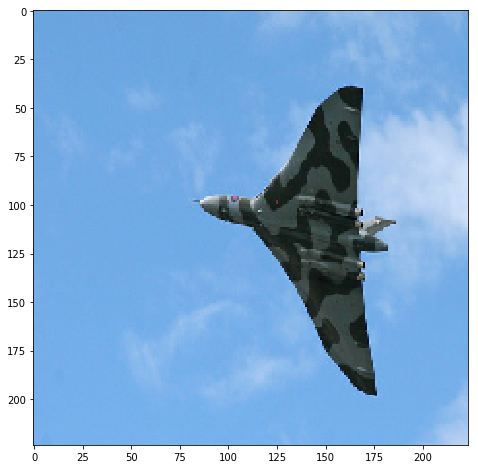

In [33]:

plt.figure(figsize=(8,8))
filename = './data/warplane2.jpg'

label=895 # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

original = load_img(filename, target_size=(224, 224))
numpy_image = img_to_array(original)
original_img_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', original_img_batch.shape)
plt.imshow(np.uint8(original_img_batch[0]))

plt.show()

In [34]:
orignal_img_prediction = kmodel.predict_on_batch(original_img_batch)
orignal_img_label = decode_predictions(orignal_img_prediction )

print(orignal_img_label[0])

[('n04552348', 'warplane', 0.8916511), ('n04592741', 'wing', 0.05332023), ('n04266014', 'space_shuttle', 0.023437275), ('n04008634', 'projectile', 0.011651035), ('n02690373', 'airliner', 0.006808288)]


The model classifies the image as a warplane with 89% accuracy.

### Applying the Attack

Steps:
    - First, call the FGMS attack
    - Second, get the gradient of the model 
    - Third, introduce the attack to the image.


In [35]:
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(numpy_image[:, :, ::-1], epsilons=1000, label=label)

The default value of the attack uses an iterable step sizes of **1000**. This is number of steps the attack iterates in the direction of the sign of the gradient. **::-1** is added to reverse the color channels of the image, because Keras ResNet50 expects BGR instead of RGB. 
Let's take al look at the attack.

In [36]:
difference = adversarial[:, :, ::-1] - numpy_image
difference[0:1,0:14]

array([[[-1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [-1.4024963,  1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [-1.4024963, -1.4024963, -1.4024963],
        [ 1.4024963,  1.4024963,  1.4024963],
        [ 1.4024963, -1.4024963,  1.4024963],
        [-1.4024963, -1.4024963, -1.4024963]]], dtype=float32)

The array shown above is the first 15 values added to the original image by the attack to create an adverserial example. To visualize the values, a little bit of agumentation is needed.

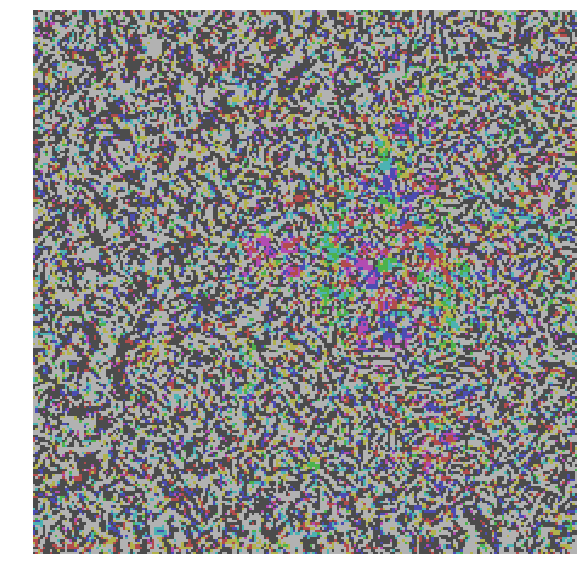

In [37]:
plt.figure(figsize=(10,10))
agumentated_adv = difference / abs(difference).max() * 0.2 + 0.5
plt.imshow(agumentated_adv)
plt.axis('off')
plt.show()

### Did adding this value changed the look of the image? 

Let's answer this question by visualizing adverserial/infected image.

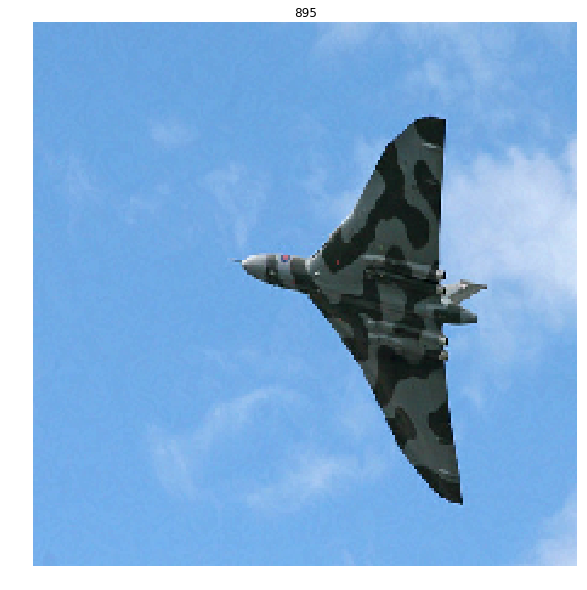

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(adversarial[:, :, ::-1]/255)
plt.title(label)
plt.axis('off')
plt.show()

### Side by side view

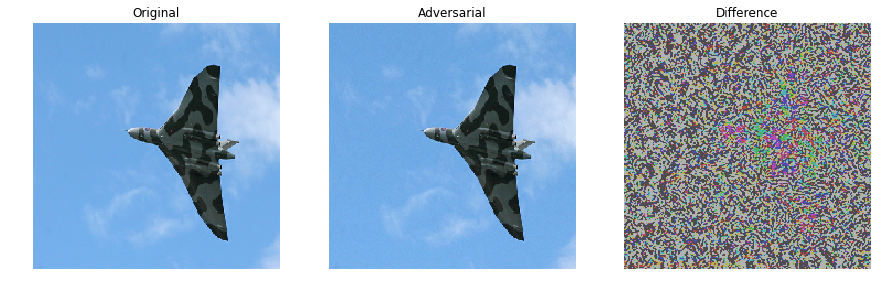

In [39]:
%matplotlib inline

plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(numpy_image / 255) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - numpy_image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

 ### Prediction

Let's use the imagenet model and predict on both the original image and the adverserial example. 
First, change each of the images to a batch format.

In [40]:
adveserial_img_batch = np.expand_dims(adversarial, axis=0)
adveserial_img_prediction = kmodel.predict_on_batch(adveserial_img_batch)
adveserial_img_label = decode_predictions(adveserial_img_prediction)
print(adveserial_img_label)

[[('n04552348', 'warplane', 0.45305192), ('n04266014', 'space_shuttle', 0.12352038), ('n02687172', 'aircraft_carrier', 0.08194003), ('n04592741', 'wing', 0.070094444), ('n04044716', 'radio_telescope', 0.06527093)]]


Accordingly, the accuracy is now down to at 45%. that's a 50% decline in accuracy.